<a href="https://colab.research.google.com/github/Niclola03/CNN-LSTM-Synthetic-Data-Sentiment-analysis/blob/main/Synthetic_Real.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Synthetic Data + Real data

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from bs4 import BeautifulSoup
import spacy
import re

In [ ]:
#df = pd.read_csv('GPTSynTrain.csv',header=None)
df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text
#Apply function on review column
df['review']=df['review'].apply(denoise_text)

#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
#Apply function on review column
df['review']=df['review'].apply(remove_special_characters)

df

<ipython-input-3-e70af21cc08f>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production The filming tech...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically theres a family where a little boy J...,negative
4,Petter Matteis Love in the Time of Money is a ...,positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,Bad plot bad dialogue bad acting idiotic direc...,negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,Im going to have to disagree with the previous...,negative


In [ ]:
#df = pd.read_csv('GPTSynTrain.csv',header=None)
df2 = pd.read_csv("GPTSynTrain.csv",on_bad_lines='skip')
df2.head()

,Text,Label
0,This movie is an absolute gem! The acting was ...,positive
1,Wow! What an incredible film! I was completely...,positive
2,Absolutely loved this movie! The characters we...,positive
3,Brilliantly done! This film is a masterpiece o...,positive
4,A must-watch for any movie lover! I couldn't t...,positive


In [ ]:
df2 =df2.rename({'Text' : 'review','Label' : 'sentiment'}, axis=1)

In [ ]:
df2.head()

,review,sentiment
0,This movie is an absolute gem! The acting was ...,positive
1,Wow! What an incredible film! I was completely...,positive
2,Absolutely loved this movie! The characters we...,positive
3,Brilliantly done! This film is a masterpiece o...,positive
4,A must-watch for any movie lover! I couldn't t...,positive


In [ ]:
df3= pd.concat([df, df2])

In [ ]:
df3.count()

review       51680
sentiment    51680
dtype: int64

<Axes: xlabel='sentiment', ylabel='count'>

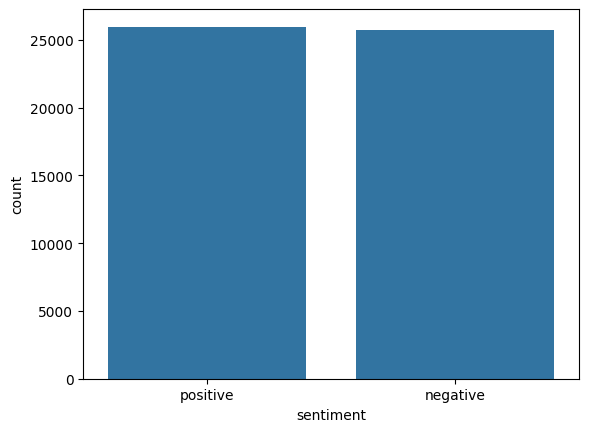

In [ ]:
# inspect sentiment
sns.countplot(x=df3['sentiment'])

In [ ]:
# text length
df3['text_length'] = df3['review'].apply(len)
df3[['sentiment','text_length','review']].head()

,sentiment,text_length,review
0,positive,1665,One of the other reviewers has mentioned that ...
1,positive,936,A wonderful little production The filming tech...
2,positive,874,I thought this was a wonderful way to spend ti...
3,negative,688,Basically theres a family where a little boy J...
4,positive,1237,Petter Matteis Love in the Time of Money is a ...


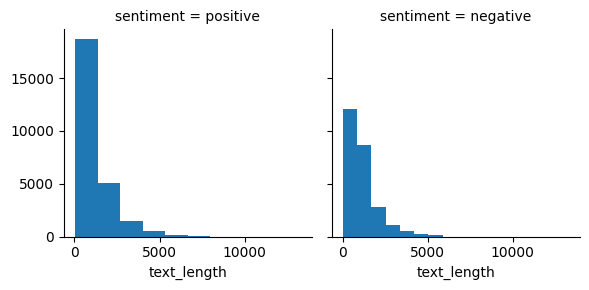

In [ ]:
g = sns.FacetGrid(df3,col='sentiment')
g.map(plt.hist,'text_length')

In [ ]:
# Encode Categorical Variable
X = df3['review']
y = pd.get_dummies(df3['sentiment']).values
num_classes = df3['sentiment'].nunique()

In [ ]:
seed = 101 # fix random seed for reproducibility
np.random.seed(seed)

In [ ]:
# Split Train Test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(41344,) (10336,) (41344, 2) (10336, 2)


In [ ]:
# Tokenize Text
from keras.preprocessing.text import Tokenizer
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

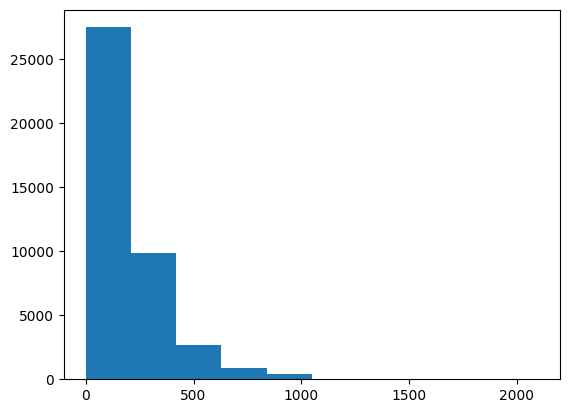

In [ ]:
totalNumWords = [len(one_comment) for one_comment in X_train]
plt.hist(totalNumWords,bins =10)
plt.show()

In [ ]:
from keras.preprocessing import sequence
max_words = 50
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_test.shape)

(41344, 50) (10336, 50)


In [ ]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense,Embedding,Conv1D,MaxPooling1D,LSTM
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

batch_size = 128
epochs = 3

In [ ]:
def get_model(max_features, embed_dim):
    np.random.seed(seed)
    K.clear_session()
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [ ]:
def model_train(model):
    # train the model
    model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                          epochs=epochs, batch_size=batch_size, verbose=2)

In [ ]:
def model_evaluate():
    # predict class with test set
    y_pred_test =  np.argmax(model.predict(X_test), axis=1)
    print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test,axis=1),y_pred_test)*100))

    #classification report
    print('\n')
    print(classification_report(np.argmax(y_test,axis=1), y_pred_test))

    #confusion matrix
    confmat = confusion_matrix(np.argmax(y_test,axis=1), y_pred_test)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

In [ ]:
# train the model
max_features = 20000
embed_dim = 1000
model = get_model(max_features, embed_dim)
model_train(model)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 1000)          20000000  
                                                                 
 conv1d (Conv1D)             (None, 50, 32)            96032     
                                                                 
 max_pooling1d (MaxPooling1  (None, 25, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 12, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 12, 32)            3

323/323 [==============================] - 4s 13ms/step
Accuracy:	83.2%


              precision    recall  f1-score   support

           0       0.85      0.81      0.83      5143
           1       0.82      0.86      0.84      5193

    accuracy                           0.83     10336
   macro avg       0.83      0.83      0.83     10336
weighted avg       0.83      0.83      0.83     10336



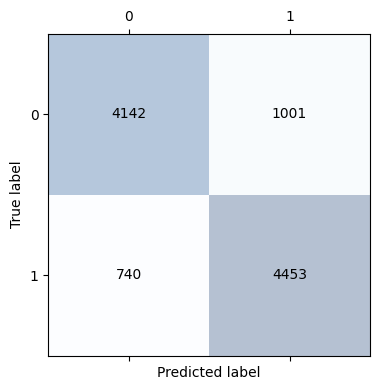

In [ ]:
# evaluate model with test set
model_evaluate()